In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import statsmodels.api as sm

import utils

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = 'data/raw/06-29/'
bids = np.load(DATA_DIR + 'bid-record.npy')
asks = np.load(DATA_DIR + 'ask-record.npy')
times = np.array(list(map(np.datetime64, map(datetime.fromtimestamp, np.load(DATA_DIR + 'time-record.npy')))))
print(bids.shape)

(200000, 256, 2)


In [3]:
def gen_graphs(df):
    plt.figure(figsize=(30,20))

    height = 4

    plt.subplot(height, 2, 1)
    plt.plot(df['dmid'][0:1000]), plt.title('dmid')
    plt.subplot(height, 2, 2)
    lags = np.arange(30) + 1
    plt.bar(lags, [df['dmid'].autocorr(lag=lag) for lag in lags]), plt.title('dmid-autocorr')

    plt.subplot(height, 2, 3)
    plt.plot(df['oir'][0:1000]), plt.title('oir')
    plt.subplot(height, 2, 4)
    lags = np.arange(30) + 1
    plt.bar(lags, [df['oir'].autocorr(lag=lag) for lag in lags]), plt.title('oir-autocorr')

    plt.subplot(height, 2, 5)
    plt.plot(df['oi'][0:300]), plt.title('oi')
    plt.subplot(height, 2, 6)
    lags = np.arange(30) + 1
    plt.bar(lags, [df['oi'].autocorr(lag=lag) for lag in lags]), plt.title('oi-autocorr')

    plt.subplot(height, 2, 7)
    lags = np.arange(30) + 1
    plt.bar(lags, [df['oi'].corr(df['dmid'].shift(lag)) for lag in lags]), plt.title('oi-dmid-corr')
    plt.subplot(height, 2, 8)
    lags = np.arange(30) + 1
    plt.bar(lags, [df['oir'].corr(df['dmid'].shift(lag)) for lag in lags]), plt.title('voi-dmid-corr')

CPU times: user 1.41 s, sys: 1.06 s, total: 2.47 s
Wall time: 2.47 s


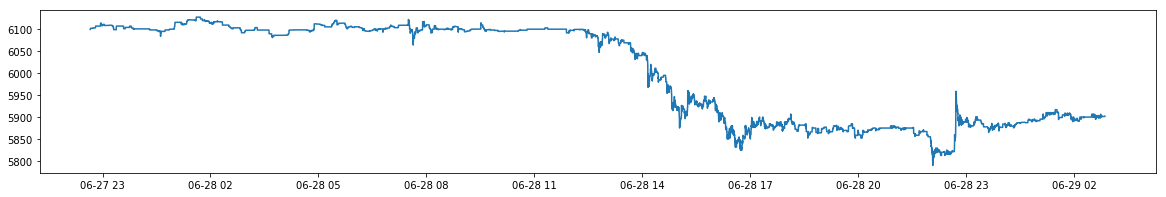

In [4]:
%%time
# construct_df(1, 20).to_pickle('data/dfs/06-19.pkl')
plt.figure(figsize=(20,3))
plt.plot_date(times, utils.construct_df(bids=bids, asks=asks, times=times,
                                        agg_sz=1, roll_mean_window_size=20)['mid'], fmt='-')

CPU times: user 1.95 s, sys: 1.02 s, total: 2.97 s
Wall time: 2.98 s


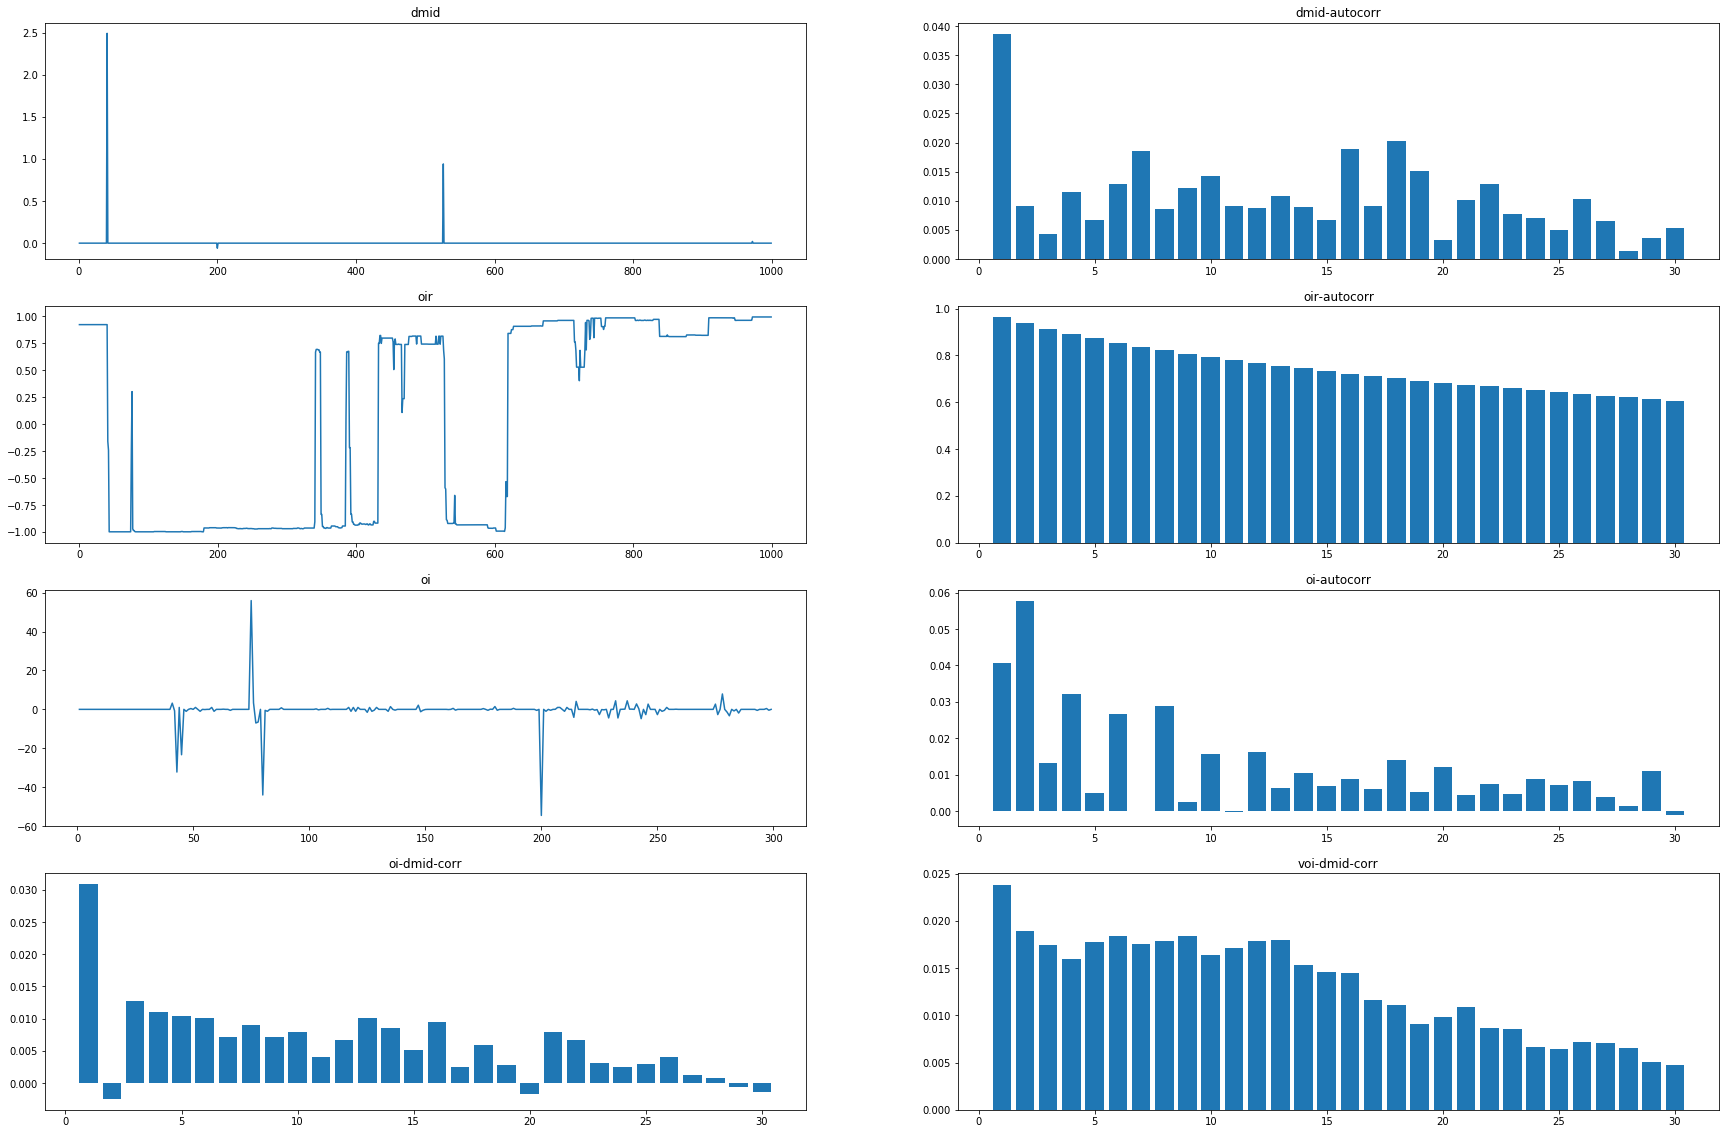

In [5]:
%%time
gen_graphs(utils.construct_df(bids=bids, asks=asks, times=times, agg_sz=1, roll_mean_window_size=20))

In [6]:
%%time
def predict(model, df, feature_history=None, feature_names=None):
    X = utils.get_feature_matrix(df,
                                 feature_history=feature_history,
                                 feature_names=feature_names,
                                 add_constant=True)
    return model.predict(X)

def fit(agg_sz=1, roll_mean_window_size=20,
        feature_history=5, feature_names=['oi'],
        df = None):
    """feature_history: how many timesteps (including current)
    counting backwards do we use for features"""

    if df is None:
        df = utils.construct_df(bids=bids, asks=asks, times=times,
                                agg_sz=agg_sz, roll_mean_window_size=roll_mean_window_size)
    
    y = utils.get_average_future_mid_change(df, future_window_size=roll_mean_window_size)

    X = utils.get_feature_matrix(df,
                                 feature_history=feature_history,
                                 feature_names=feature_names,
                                 add_constant=True)

    model = sm.OLS(y, X, missing = 'drop')
    results = model.fit()
    
    return results

print((fit(feature_names=['oi']).rsquared_adj,
       fit(feature_names=['oir']).rsquared_adj,
       fit(feature_names=['oi', 'oir']).rsquared_adj))

(0.03188289620690188, 0.06504610795309917, 0.07773666996291662)
CPU times: user 4.27 s, sys: 3.09 s, total: 7.37 s
Wall time: 7.29 s


In [9]:
%%time
rsquared_adj = []
best_rsquared_adj = 0.0
for agg_sz in [0.1, 0.5, 1, 5]:
    for roll_mean_window_size in [10, 100, 1000]:
        for feature_history in [5, 10, 20, 50]:
            model = fit(agg_sz=agg_sz,
                        roll_mean_window_size=roll_mean_window_size,
                        feature_history=feature_history,
                        feature_names=['oir', 'oi'])
            rsquared_adj.append((model.rsquared_adj, agg_sz, roll_mean_window_size, feature_history))
            if model.rsquared_adj > best_rsquared_adj:
                best_rsquared_adj = model.rsquared_adj
                print(model.rsquared_adj, agg_sz, roll_mean_window_size, feature_history)

0.054499879915213656 0.1 10 5
0.058393200361494535 0.1 10 10
0.06188182008383991 0.1 10 20
0.06387421226119139 0.1 10 50
0.07721531303055329 0.1 100 5
0.07888434873191641 0.1 100 10
0.07974779048003489 0.1 100 20
0.08096486416405124 0.5 100 10
0.08171931857187276 0.5 100 20
0.08273007446143021 1 100 10
0.08344283392307394 1 100 20
0.08351060953584144 5 100 50
CPU times: user 3min 9s, sys: 1min, total: 4min 10s
Wall time: 3min 10s


In [10]:
rsquared_adj.sort()
for row in rsquared_adj[:-10:-1]:
    print(row)

(0.08351060953584144, 5, 100, 50)
(0.08344283392307394, 1, 100, 20)
(0.08337102556680454, 1, 100, 50)
(0.08329721712544336, 5, 100, 20)
(0.08273007446143021, 1, 100, 10)
(0.08207059749500278, 5, 100, 10)
(0.08171931857187276, 0.5, 100, 20)
(0.081643587530699, 0.5, 100, 50)
(0.08121582207351274, 1, 100, 5)


In [11]:
def backtest(agg_sz=1,
             roll_mean_window_size=100,
             feature_history=20,
             feature_names=None,
             initial_position=0,
             taker_fee=3e-3,
             train_frac=0.5,
             trade_thresh=1):
    """
    train_frac: What percentage of the data (taken as prefix) should be used for train.
                The remainder is used for test.
    trade_thresh: What our linear model needs to produce in order for us to update our position. positive.
    taker_fee: percentage, default is given in https://docs.gdax.com/#trading-fees
    """

    df_ = utils.construct_df(bids=bids, asks=asks, times=times,
                             agg_sz=agg_sz, roll_mean_window_size=roll_mean_window_size)
    
    train_sz = round(df_.shape[0] * train_frac)    
    train_df = df_[:train_sz]
    test_df = df_[train_sz:]
    # df_ should not be used from this point onwards
    
    model = fit(agg_sz=agg_sz,
                roll_mean_window_size=roll_mean_window_size,
                feature_history=feature_history,
                feature_names=feature_names,
                df=train_df)
    
    preds = pd.Series(predict(model, test_df,
                              feature_history=feature_history,
                              feature_names=feature_names))
    
    bull_times = preds > trade_thresh
    bear_times = preds < -trade_thresh
    bear_times *= 1 - bull_times # due to NaNs, we want to enforce that we never have both a buy and sell
    
    portfolio = utils.create_portfolio(bull_times=bull_times,
                                       bear_times=bear_times,
                                       initial_position=initial_position)
    
    taker_fees = utils.compute_taker_fees(test_df, portfolio, taker_fee=taker_fee)
    
    returns = pd.Series(test_df['dmid'].values)
    portfolio_returns = portfolio * returns
    
    mid_times = pd.Series(test_df['time'].values)
    
    # returns are returns on bitcoin
    # portfolio returns are returns on portfolio without taker fees
    # taker fees are the fees associated with trading (always positive)
    return returns, portfolio_returns, taker_fees, mid_times, preds

Sharpe Ratio: -0.016519308406096726
Earnings: -1145.5238800000025
Max prediction: 3.2551798828382745


No handles with labels found to put in legend.


CPU times: user 4.52 s, sys: 1.17 s, total: 5.7 s
Wall time: 5.41 s


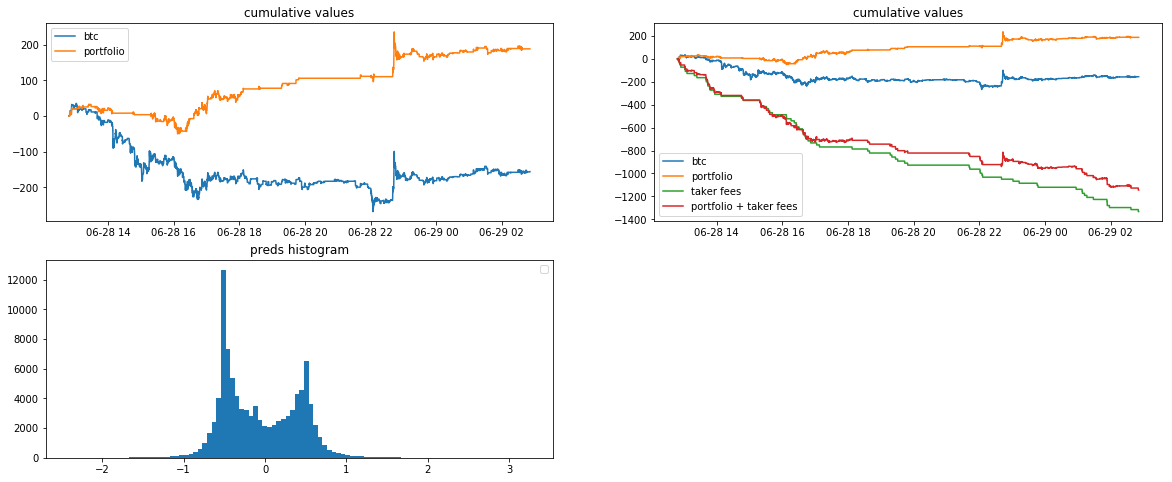

In [15]:
%%time
r, pr, tf, t, preds = backtest(agg_sz=1,
                               roll_mean_window_size=100,
                               feature_history=20,
                               feature_names=['oir', 'oi'],
                               taker_fee=3e-3,
                               initial_position=0,
                               trade_thresh=1)
print("Sharpe Ratio:", utils.get_sharpe_ratio(pr - tf, r))
print("Earnings:", pr.sum() - tf.sum())
print("Max prediction:", preds.max())

plt.figure(figsize=(20,8))

plt.subplot(2, 2, 1)
plt.plot_date(t, r.cumsum(), label='btc', fmt='-')
plt.plot_date(t, pr.cumsum(), label='portfolio', fmt='-')
plt.title('cumulative values')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot_date(t, r.cumsum(), label='btc', fmt='-')
plt.plot_date(t, pr.cumsum(), label='portfolio', fmt='-')
plt.plot_date(t, -tf.cumsum(), label='taker fees', fmt='-')
plt.plot_date(t, pr.cumsum() - tf.cumsum(), label='portfolio + taker fees', fmt='-')
plt.title('cumulative values')
plt.legend()

plt.subplot(2, 2, 3)
plt.hist(preds.dropna(), bins=100)
plt.title('preds histogram')
plt.legend()